<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/resnet_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title from drive
from google.colab import drive
drive.mount('/content/drive') # mount to google drive
!unzip /content/drive/MyDrive/extra/iras/google_street_view.zip -d /content # unzip google_street_view.zip
import shutil
shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

In [ ]:
# @title download
# https://drive.google.com/file/d/1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q/view?usp=sharing
!gdown 1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q -O gsv.zip
!unzip /content/gsv.zip -d /content
import shutil
shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

# https://bestasoff.medium.com/how-to-fine-tune-very-large-model-if-it-doesnt-fit-on-your-gpu-3561e50859af
!pip install bitsandbytes


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py

from PIL import ImageOps, ImageFilter
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            # return img.filter(ImageFilter.GaussianBlur(sigma))
            return transforms.GaussianBlur(kernel_size=5, sigma=sigma)(img)
        else:
            return img

class Solarization(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

class Cutout(object):
    def __init__(self, p=0.5, mask_size=140, mask_color=(0, 0, 0)):
        self.p = p
        self.mask_size = mask_size
        self.mask_color = mask_color
        self.mask_size_half = self.mask_size // 2
        # offset = 1 if mask_size % 2 == 0 else 0
    def __call__(self, img):
        if np.random.rand() > self.p:
            return img
        else:
            img = np.asarray(img).copy()
            h, w = img.shape[:2] # 480x600
            cx = np.random.randint(0, w)
            cy = np.random.randint(0, h)
            xmin, xmax = cx - self.mask_size_half, cx + self.mask_size_half
            ymin, ymax = cy - self.mask_size_half, cy + self.mask_size_half
            xmin, xmax = max(0, xmin), min(w, xmax)
            ymin, ymax = max(0, ymin), min(h, ymax)
            img[ymin:ymax, xmin:xmax] = self.mask_color
            return img


class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                # transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5), # 0.5
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,), # brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8
                transforms.RandomGrayscale(p=0.2), # 0.2
                # GaussianBlur(p=1.0), # 1.0
                # Solarization(p=0.0), # 0.0
                Cutout(p=1.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225
            ])

    def __call__(self, sample):
        x1 = self.transform(sample)
        # x2 = transforms.ToTensor()(sample)
        return x1
# https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py



# https://github.com/hysts/pytorch_cutout/blob/master/dataloader.py
# https://arxiv.org/pdf/1708.04552.pdf
# size of the cutout region is a more important hyperparameter than the shape
# randomly select a pixel coordinate within the image as a center point and then place the cutout mask around that location.
# alternative randomly apply cutout constrained within the image region, but with 50% probability so that the network sometimes receives unmodified images
def cutout(p=0.5, mask_size=16, mask_color=(0, 0, 0)):
    mask_size_half = mask_size // 2
    # offset = 1 if mask_size % 2 == 0 else 0
    def _cutout(image):
        image = np.asarray(image).copy()
        if np.random.random() > p:
            return image
        h, w = image.shape[:2]
        cx = np.random.randint(0, w)
        cy = np.random.randint(0, h)
        xmin, xmax = cx - mask_size_half, cx + mask_size_half
        ymin, ymax = cy - mask_size_half, cy + mask_size_half
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
        return image
    return _cutout



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


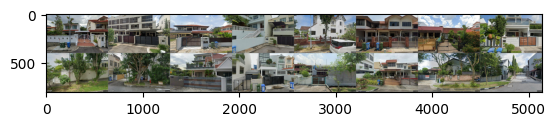

In [ ]:
# @title data
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(transforms.ToTensor())

dir='/content/google_street_view'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)
train_data, test_data = torch.utils.data.random_split(data, [.85,.15])


from torch.utils.data import Dataset
class DatasetWrap(Dataset):
    def __init__(self, dataset, transform=None):
        super(DatasetWrap, self).__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
# train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
train_data = DatasetWrap(train_data, transform)
test_data = DatasetWrap(test_data, transform)


batch_size = 16 # 64
num_batches=int(np.ceil(len(train_data)/batch_size))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
# dataiter=None

# dataiter = iter(test_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images))
# dataiter=None


In [ ]:
%matplotlib inline 
# images, labels = next(dataiter)

# from matplotlib import pyplot as plt
image=images[0]
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()


In [ ]:
# @title pretrained
import torch
import torch.nn as nn

from torchvision import datasets, models, transforms
# https://pytorch.org/vision/0.12/models.html#id10
model = models.resnet152(pretrained=True) # 18 34 50 101 152

# https://pytorch.org/vision/main/models/vision_transformer.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16
# model = models.vit_b_16(weights='DEFAULT') # small vit_b_16 vit_b_32 vit_l_16 vit_l_32 vit_h_14 big

num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 6),
    nn.Softmax(dim=1),
    )
# model.mods = [module for k, module in model._modules.items()]
# modules = [module for k, module in model._modules.items()]


# num_ftrs = model.heads.head.in_features
# # model.fc = nn.Linear(num_ftrs, 2)
# model.heads = nn.Sequential(
#     nn.Linear(num_ftrs, 6),
#     nn.Softmax(dim=1),
#     )


# c=0
# for param in model.parameters():
#     # print(c, param.shape)
#     if c>=0: #18(61) 101(312) 152(466)
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
#     c+=1

# for param in model.parameters():
#     print(param.requires_grad,param.shape)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
model = torch.compile(model.to(device),mode='reduce-overhead')

# print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# @title try

# # check model's input and output dimensions are correct
# X = torch.rand(64, 3, 32, 32, device=device)
# logits = model(X)
# print(logits.shape)
# # print(logits[0])
# # print(logits[0].argmax(1))
# pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = pred_probab.argmax(1)
# print(y_pred)


loss_fn = nn.CrossEntropyLoss()

base_lr, max_lr = 1e-5, 1e-4 # 1e-5, 1e-3 #0.5#
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1

epochs = 5 #5 20
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)

# from torch.distributed.optim import ZeroRedundancyOptimizer
# optimizer = ZeroRedundancyOptimizer(model.parameters(), optimizer_class=torch.optim.Adam, lr=base_lr)


import bitsandbytes as bnb
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)

div_factor = max_lr/base_lr
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batchess, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)


strain(train_loaders, model, loss_fn, optimizer)
# accuracy, test_loss = test(test_loaders, model, loss_fn)


torch.Size([64, 10, 1, 1])


In [ ]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()
# https://github.com/prigoyal/pytorch_memonger/blob/master/models/optimized/resnet_new.py
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# train function with automatic mixed precision
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(): # automatic mixed percision
            # pred = model(sx)

            modules = [module for k, module in model._modules.items()]
            pred = checkpoint_sequential(functions=modules, segments=1, input=sx) # gradient checkpointing
            # pred = checkpoint_sequential(functions=model.mods, segments=1, input=sx)

            loss = loss_fn(pred, sy)
        
        scaler.scale(loss).backward()
        if ((batch + 1) % 4 == 0) or (batch + 1 == len(dataloader)): # gradient accumulation
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        loss_list.append(loss.item())
        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss


In [ ]:
# @title lrfinder data

data = datasets.ImageFolder(dir, transform=transforms.ToTensor())
torch.manual_seed(0)
train_data, test_data = torch.utils.data.random_split(data, [.85,.15])
print(len(train_data))
print(len(test_data))

a=0.15 # 0.2 # proportion of train data to train on
train_sets,_ = torch.utils.data.random_split(train_data, [a, 1-a])
test_sets,_ = torch.utils.data.random_split(test_data, [a, 1-a])

batch_size=16#64
num_batchess=int(np.ceil(len(train_data)/batch_size))
train_loaders = torch.utils.data.DataLoader(train_sets, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loaders = torch.utils.data.DataLoader(test_sets, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None

pth='/content/lr.pth'
torch.save(model.state_dict(), pth) # save temporary model for lr finding


8624
1521


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

gamma 1.4125375446227544
lr:  1e-07


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 1.815421  [    0/ 1294]
loss: 1.813760  [  128/ 1294]
loss: 1.814063  [  256/ 1294]
loss: 1.820777  [  384/ 1294]
loss: 1.817525  [  512/ 1294]
loss: 1.809415  [  640/ 1294]
loss: 1.824809  [  768/ 1294]
loss: 1.810498  [  896/ 1294]
loss: 1.807294  [ 1024/ 1294]
loss: 1.805825  [ 1152/ 1294]


[2023-05-10 09:33:10,192] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation
[2023-05-10 09:33:43,974] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation


Accuracy: 3.1%, Avg loss: 1.812099
lr:  1.4125375446227544e-07


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 1.818756  [    0/ 1294]
loss: 1.789334  [  128/ 1294]
loss: 1.822371  [  256/ 1294]
loss: 1.810111  [  384/ 1294]
loss: 1.816852  [  512/ 1294]
loss: 1.807596  [  640/ 1294]
loss: 1.805033  [  768/ 1294]
loss: 1.814807  [  896/ 1294]
loss: 1.821844  [ 1024/ 1294]
loss: 1.822529  [ 1152/ 1294]
Accuracy: 3.1%, Avg loss: 1.811675
lr:  1.9952623149688798e-07
loss: 1.803567  [    0/ 1294]
loss: 1.823984  [  128/ 1294]
loss: 1.803779  [  256/ 1294]
loss: 1.821974  [  384/ 1294]
loss: 1.791632  [  512/ 1294]
loss: 1.806149  [  640/ 1294]
loss: 1.807009  [  768/ 1294]
loss: 1.805837  [  896/ 1294]
loss: 1.800181  [ 1024/ 1294]
loss: 1.825148  [ 1152/ 1294]
Accuracy: 3.1%, Avg loss: 1.809620
lr:  2.8183829312644544e-07
loss: 1.823700  [    0/ 1294]
loss: 1.822709  [  128/ 1294]
loss: 1.798477  [  256/ 1294]
loss: 1.819896  [  384/ 1294]
loss: 1.825751  [  512/ 1294]
loss: 1.825026  [  640/ 1294]
loss: 1.821125  [  768/ 1294]
loss: 1.807029  [  896/ 1294]
loss: 1.809306  [ 1024/ 1294]
loss

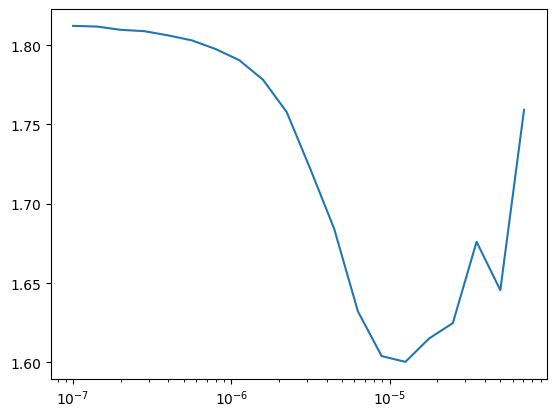

In [ ]:
# @title lrfinder

# https://towardsdatascience.com/super-convergence-with-just-pytorch-c223c0fc1e51
# https://github.com/davidtvs/pytorch-lr-finder

# from fastai.vision.all import *
# # https://docs.fast.ai/learner.html#learner
# # learn = cnn_learner(train_loaders, model, loss_fn)
# learn = vision_learner(train_loaders, model, loss_fn)
# # vision_learner
# # https://docs.fast.ai/tutorial.vision.html
# learn.lr_find()
# # https://pypi.org/project/torch-lr-finder/


# # https://arxiv.org/pdf/1506.01186.pdf
# LR range test
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall

# https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

num_iter=20#20 # num of lr data points
start_lr= 1e-7 # 1e-6
end_lr= 1e-4 # 1e-2
# 152: 1e-7 - 1e-4


loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)

import bitsandbytes as bnb
optimizer = bnb.optim.Adam(model.parameters(), lr=start_lr, betas=(0.9, 0.999), optim_bits=8)



def lrfinder(model, optimizer, loss_fn, train_loaders, test_loaders, start_lr=0.0001, end_lr=0.1, num_iter=20, train_batches=100, test_batches=20):
    acc_list=[]
    lr_list=[]
    test_list=[]
    for i in range(num_iter):
        model.load_state_dict(torch.load("lr.pth"))

        lr=scheduler.get_last_lr()[0]
        # lr=scheduler.get_lr()[0]
        # lr=optimizer.param_groups[0]["lr"]
        print("lr: ",lr)
        lr_list.append(lr)

        strain(train_loaders, model, loss_fn, optimizer)
        # train(train_loaders, model1, loss_fn, optimizer)
        
        scheduler.step()
        accuracy, test_loss = test(test_loaders, model, loss_fn)
        acc_list.append(accuracy)
        test_list.append(test_loss)
    return lr_list,acc_list,test_list


# (end_lr/start_lr)=gamma**(num_iter)
gamma = np.exp(np.log(end_lr/start_lr)/num_iter)
print("gamma",gamma)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)


# lrfinder(model, optimizer, loss_fn, train_loaders, test_loaders, start_lr=0.0001, end_lr=0.1, num_iter=20, train_batches=100, test_batches=20):
# lr_list,acc_list = lrfinder(model, optimizer, loss_fn)#, train_loaders, end_lr, num_iter)
lr_list,acc_list,test_list = lrfinder(model, optimizer, loss_fn, train_loaders, test_loaders)# end_lr, num_iter)
import matplotlib.pyplot as plt
# plt.plot(lr_list, acc_list)
plt.plot(lr_list, test_list)
plt.xscale('log')
plt.show()
plt.close()


Epoch 1
-------------------------------
3.000000000000001e-07


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss: 1.447749  [    0/ 8624]
loss: 1.403282  [  848/ 8624]
loss: 1.414563  [ 1696/ 8624]
loss: 1.506713  [ 2544/ 8624]
loss: 1.316478  [ 3392/ 8624]
loss: 1.482348  [ 4240/ 8624]
loss: 1.446724  [ 5088/ 8624]
loss: 1.436853  [ 5936/ 8624]
loss: 1.374220  [ 6784/ 8624]
loss: 1.437962  [ 7632/ 8624]
loss: 1.292280  [ 8480/ 8624]
Accuracy: 48.5%, Avg loss: 1.550090
Epoch 2
-------------------------------
1.4171070476680746e-06
loss: 1.489874  [    0/ 8624]
loss: 1.471951  [  848/ 8624]
loss: 1.443135  [ 1696/ 8624]
loss: 1.490870  [ 2544/ 8624]
loss: 1.478491  [ 3392/ 8624]
loss: 1.444441  [ 4240/ 8624]
loss: 1.351120  [ 5088/ 8624]
loss: 1.345517  [ 5936/ 8624]
loss: 1.557878  [ 6784/ 8624]
loss: 1.419977  [ 7632/ 8624]
loss: 1.503194  [ 8480/ 8624]
Accuracy: 51.3%, Avg loss: 1.527503
Epoch 3
-------------------------------
2.9196457374135102e-06
loss: 1.501846  [    0/ 8624]
loss: 1.305637  [  848/ 8624]
loss: 1.333363  [ 1696/ 8624]
loss: 1.317654  [ 2544/ 8624]
loss: 1.567613  [ 3392

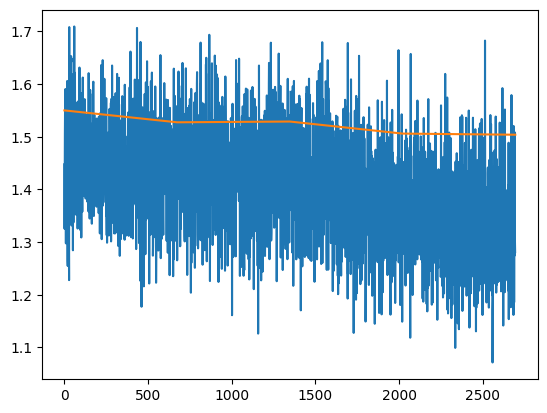

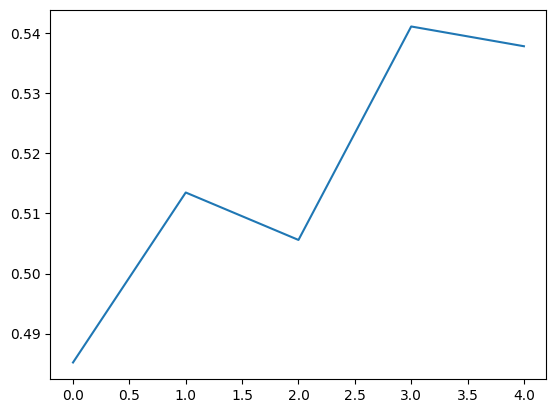

In [ ]:
# @title wwwwwwwww
import time
start = time.time()
acc_lst, train_lst, test_lst=[],[],[]
loss_fn = nn.CrossEntropyLoss()


base_lr, max_lr = 3e-7, 3e-6 # 1e-5, 1e-3 #0.5#
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1

# print(num_batches)
epochs = 5 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), optim_bits=8)

div_factor = max_lr/base_lr
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)
total_steps=num_batches*epochs


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    print(lr)
    # train(train_loader, model, loss_fn, optimizer)
    train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    # strain(train_loader, model, loss_fn, optimizer, scheduler)
    correct, test_loss = test(test_loader, model, loss_fn)
    # scheduler.step()
    train_lst.extend(train_ls)
    test_lst.append(test_loss)
    acc_lst.append(correct)
print("Done!")

end = time.time()
print("time: ",end - start)

print(len(train_lst), len(test_lst))
import matplotlib.pyplot as plt
plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()


torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

# resnet 18, 60/61 38.4%, 528s
# resnet 18, 58/61 39.8%, 523s
# resnet 18 compile , 58/61 40.4%, 555s
# resnet 18 compile augment , 58/61 36.4%, 1941 # augment on cpu, takes longer
# resnet 18 augment lr3e-4:3e-3, 58/61 37.7%, 1863s
# resnet 18 augment 10epoch lr1e-5:3e-4, 58/61 33.5%, 3387s
# resnet 18 compile lr1e-5:3e-4, 58/61 35.0%, 493s
# resnet 18 compile scratch lr1e-5:1e-3, 58/61 26.8%, 475s
# resnet 18 compile lr1e-5:1e-3, 55/61 47.3%, 480s
# resnet 18 compile lr1e-5:1e-3, 52/61 51.7% 503s
# resnet 18 compile lr1e-5:1e-3, unfreeze 51.0%, 550s
# resnet 18 compile lr1e-5:1e-4, unfreeze 52.7%, 518s
# resnet 34 compile lr1e-5:1e-4, unfreeze bitsadamW batch16*4
# resnet 152 compileoverhead lr3e-7:3e-6, bitsadamW batch16*4 ckpt 53.8%, 2066
# resnet 152 from53.8% augment+cutout lr3e-7:3e-6, 53.8%, 2088



In [ ]:
print(len(train_lst), len(test_lst))
import matplotlib.pyplot as plt
plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pth='/content/drive/MyDrive/frame/res152.pth'

# torch.save(model.state_dict(), pth)
# model.load_state_dict(torch.load("model.pth"))


In [ ]:
# test(test_loader, model, loss_fn)

In [ ]:
dir='/content/google_street_view'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)
train_data, test_data = torch.utils.data.random_split(data, [.85,.15])


from torch.utils.data import Dataset
class DatasetWrap(Dataset):
    def __init__(self, dataset, transform=None):
        super(DatasetWrap, self).__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
# train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
train_data = DatasetWrap(train_data, transform)
test_data = DatasetWrap(test_data, transform)


batch_size = 16 # 64
num_batches=int(np.ceil(len(train_data)/batch_size))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None



In [ ]:
# @title trash
# a = []
# while(1):
#     a.append(‘1’)

# train_data, test_data = None, None

# gc.collect() # Python thing

# torch.cuda.empty_cache() # PyTorch thing

# device = cuda.get_current_device() 
# device.reset()

# clear gpu memory
from numba import cuda
cuda.select_device(0)
cuda.close()


In [ ]:
# @title store
import torch
import torch.nn as nn

# https://pytorch.org/vision/0.12/models.html#id10
model = models.resnet152(pretrained=True) # 18 34 50 101 152
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Softmax(dim=1),
    )

c=0
for param in model.parameters():
    # print(c, param.shape)
    if c>=461: #101(312) 152(466)
        param.requires_grad = True
    else:
        param.requires_grad = False
    c+=1

model = model.to(device)


for lr in [1e-3,3e-4,1e-4,3e-5,1e-5]:
    
